# Necker Cube Surface Geodesics
Credits:
Pavel Javornik -- CubeSurf, 3D Mapping


Pat Hooper -- SurfaceToSpaceMapping, SurfaceToPlaneMapping, CubeSurfaceProjection


Here is an outline of how our model for studying geodesics on the Necker cube surface works. This is how we get all our pretty pictures!


It is crucial to note that you \emph{need} to install flatsurf to make this work.
The first few pages is just a general set-up to get a nice visualization of geodesic flow. The file gets more interactive later on.

In [35]:
from flatsurf import *
from flatsurf.geometry.straight_line_trajectory import StraightLineTrajectory

In [2]:
class SurfaceToSpaceMapping(SageObject):
    def __init__(self, similarity_surface, tranformation):
        self._s=similarity_surface
        from types import FunctionType
        if isinstance(transformation,FunctionType):
            self.transformation=transformation
        
    def transformation(self, label):
        r"""
        Return a pair (m,t) where m is a 3x2 matrix and v is a vector with 3 entries.
        The associated tranformation from the polygon with the given label is v mapsto
        m*v+t where v is a point in the polygon.
        """
        return self._t[label]
    
    def image_polygon(self,label):
        r"""
        Return a 2-dimensional polyhedron in 3-space representing the image of the polygon with the given label.
        """
        p = self._s.polygon(label)
        m,t = self.transformation(label)
        vertices = [ m*v+t for v in p.vertices() ]
        return Polyhedron(vertices=vertices)
    
    def plot(self, labels, point=False, line=False, polygon=None, wireframe=None, frame=False, label_to_color=None):
        r"""
        Return a 3d plot of the polygonal images in 3-space corresponding to the collection of labels.
        The other parameters are passed to a Polyhedron.plot method and affect the rendering.
        """
        it = iter(labels)
        label = it.next()
        if label_to_color is None:
            p = self.image_polygon(label).plot(point=point, line=line, polygon=polygon, \
                                               wireframe=wireframe,frame=frame,color="pink")
        else:
            p = self.image_polygon(label).plot(point=point, line=line, polygon=polygon, \
                                               wireframe=wireframe,frame=frame,color=label_to_color(label))            
        for label in it:
            if label_to_color is None:
                p += self.image_polygon(label).plot(point=point, line=line, polygon=polygon, \
                                                   wireframe=wireframe,frame=frame,color="pink")
            else:
                p += self.image_polygon(label).plot(point=point, line=line, polygon=polygon, \
                                                   wireframe=wireframe,frame=frame,color=label_to_color(label)) 
        from sage.modules.free_module_element import vector
        p.frame_aspect_ratio(tuple(vector(p.bounding_box()[1])-vector(p.bounding_box()[0])))
        return p

    def __call__(self,o):
        r"""
        This method is used to convert from an object on the surface to an object in space.
        
        Currently works with 
        - StraightLineTrajectory -- returns the corresponding list of points in space
        - SegmentInPolygon -- returns the corresponding pair of points in space
        - SimilaritySurfaceTangentVector -- returns a pair of points corresponding to the image point and image of the tangent vector.
        """
        
        if isinstance(o, StraightLineTrajectory):
            points=[]
            it = iter(o.segments())
            s=it.next()
            label = s.polygon_label()
            m,t = self.transformation(label)
            
            points.append(t + m*s.start().point())
            points.append(t + m*s.end().point())
            for s in it:
                label = s.polygon_label()
                m,t = self.transformation(label)
                points.append(t + m*s.end().point())
            return points
        if isinstance(o, SegmentInPolygon):
            # Return the pair of images of the endpoints.
            label = o.polygon_label()
            m,t = self.transformation(label)
            return ( t+m*o.start().point(), t+m*o.end().point() )
        if isinstance(o,SimilaritySurfaceTangentVector):
            # Map to a pair of vectors consisting of the image of the basepoint and the image of the vector.
            label = o.polygon_label()
            m,t = self.transformation(label)
            point = o.point()
            vector = o.vector()
            return (t + m*point, m*vector)
        raise ValueError("Failed to recognize type of passed object")

In [3]:
class SurfaceToPlaneMapping(SageObject):
    def __init__(self, similarity_surface, transformation, default_polygon_options):
        r"""
        Transformation should be a function sending labels to
        elements of an `AffineGroup` of a 2-dimensional vector
        space.
        """
        self._s=similarity_surface
        self._t = transformation
        self._o = default_polygon_options
        
    def transformation(self, label):
        r"""
        Return a pair (m,t) where m is a 3x2 matrix and v is a vector with 3 entries.
        The associated tranformation from the polygon with the given label is v mapsto
        m*v+t where v is a point in the polygon.
        """
        return self._t(label)
    
    def image_polygon(self, label, options=None):
        r"""
        Return a 2-dimensional polyhedron in 3-space representing the image of the polygon with the given label.
        """
        p = self._s.polygon(label)
        t = self.transformation(label)
        if options is None:
            options = self._o(label)
        vertices = [ t(v) for v in p.vertices() ]
        return polygon2d(vertices, **options)
    
    def plot(self, labels, **options):
        r"""
        Return a 3d plot of the polygonal images in 3-space corresponding to the collection of labels.
        The other parameters are passed to a Polyhedron.plot method and affect the rendering.
        """
        it = iter(labels)
        label = it.next()
        p = self.image_polygon(label).plot(**options)
        for label in it:
            p += self.image_polygon(label).plot()
        return p

    def plot_cylinder(self, cyl, **options):
        assert self._s == cyl.surface(), "Cylinder must be a surface on the correct surface."
        plt = Graphics()
        for label, polygon in cyl.polygons():
            t = self.transformation(label)
            vertices = [ t(v) for v in polygon.vertices() ]
            plt += polygon2d(vertices, **options).plot()
        return plt
    
    def __call__(self,o):
        r"""
        This method is used to convert from an object on the surface to an object in space.
        
        Currently works with 
        - StraightLineTrajectory -- returns the corresponding list of points in space
        - SegmentInPolygon -- returns the corresponding pair of points in space
        - SimilaritySurfaceTangentVector -- returns a pair of points corresponding to the image point and image of the tangent vector.
        """
        
        if isinstance(o, StraightLineTrajectory):
            points=[]
            it = iter(o.segments())
            s=it.next()
            label = s.polygon_label()
            t = self.transformation(label)
            
            points.append(t(s.start().point()))
            points.append(t(s.end().point()))
            for s in it:
                label = s.polygon_label()
                t = self.transformation(label)
                points.append(t(s.end().point()))
            return points
        if isinstance(o, SegmentInPolygon):
            # Return the pair of images of the endpoints.
            label = o.polygon_label()
            t = self.transformation(label)
            return ( t(o.start().point()), t(o.end().point()) )
        raise ValueError("Failed to recognize type of passed object")    

This defines the Necker Cube surface:

In [4]:
from flatsurf.geometry.surface import Surface
from flatsurf.geometry.polygon import Polygons
from flatsurf.geometry.similarity import SimilarityGroup
class CubeSurf(Surface):
    def __init__(self,F):
        ZZ3=IntegerModRing(3)
        P=Polygons(F)
        self._faceA=P(vertices=[(0,0),(1,0),(1,1),(0,1)])
        self._faceB=P(vertices=[(0,0),(1,0),(1,1),(0,1)])
        self._faceC=P(vertices=[(0,0),(1,0),(1,1),(0,1)])
        Surface.__init__(self,F,(ZZ(0),ZZ(0),ZZ3(0)), finite=False)
    def polygon(self, label):
        x,y,l=label
        if l==0:
            return self._faceA
        if l==1:
            return self._faceB
        if l==2:
            return self._faceC
    def opposite_edge(self,label,edge):
        x,y,l=label
        ## l(0)=A l(1)=B l(2)=C
        if l==0:
            if edge==0:
                return((x,y-1,l+2),2)
            if edge==1:
                return((x,y,l+1),3)
            if edge==2:
                return((x,y,l+2),0)
            if edge==3:
                return((x-1,y,l+1),1)
        if l==1:
            if edge==0:
                return((x+1,y-1,l+1),3)
            if edge==1:
                return((x+1,y,l+2),3)
            if edge==2:
                return((x,y,l+1),1)
            if edge==3:
                return((x,y,l+2),1)
        if l==2:
            if edge==0:
                return((x,y,l+1),2)
            if edge==1:
                return((x,y,l+2),2)
            if edge==2:
                return((x,y+1,l+1),0)
            if edge==3:
                return((x-1,y+1,l+2),0)
SG=SimilarityGroup(QQ)
def default_position(label):
    x,y,l = label
    if(ZZ(l)==0):
        return SG(2*x,2*y) #(b+c)x,(a+c)y
    if(ZZ(l)==1):
        return SG(2*x+1,2*y) #(b+c)x + c, (a+c)y
    if(ZZ(l)==2):
        return SG(2*x,2*y+1) #(b+c)x, (a+c)y + c
    ##Reminder to parameterize a,b,c here for positions.
    ##Rework this to work for surfaces of different sizes.

In [5]:
s=ConeSurface(CubeSurf(QQ))

In [6]:
# For the 3D mapping:

MM=matrix(QQ,[
    [0,1,0],
    [-1,0,0],
    [0,0,1]
])

def transformation(label):
    M=MatrixSpace(QQ,3,2)
    V=VectorSpace(QQ,3)
    x,y,l=label
    if l==0:
        return MM*M([[1,0],[0,1],[0,0]]),MM*V([x,y,-x-y])
    elif l==1:
        return MM*M([[0,0],[0,1],[-1,0]]),MM*V([x+1,y,-x-y])
    else: # l==2
        return MM*M([[1,0],[0,0],[0,-1]]),MM*V([x,y+1,-x-y])

m3d = SurfaceToSpaceMapping(s,transformation)

def label_to_color(label):
    if label[2]==0:
        return "pink"
    if label[2]==1:
        return "yellow"
    if label[2]==2:
        return "beige"

In [7]:
# For the 2D projection:
class CubeSurfaceProjection(SageObject):
    def __init__(self, v1, v2, v3):
        r"""
        The vectors should be the three vector images of the edges.
        """
        self._v1 = vector(v1)
        self._v2 = vector(v2)
        self._v3 = vector(v3)
        self._m0 = matrix([v1, v2]).transpose()
        self._m1 = matrix([-v3, v2]).transpose()
        self._m2 = matrix([v1, -v3]).transpose()
        self._A = AffineGroup(v1.parent())

    def __call__(self, label):
        m,n,l = label
        if l==0:
            return self._A(self._m0, m*self._v1 + n*self._v2 - (m+n)*self._v3)
        if l==1:
            return self._A(self._m1, (m+1)*self._v1 + n*self._v2 - (m+n)*self._v3)
        if l==2:
            return self._A(self._m2, m*self._v1 + (n+1)*self._v2 - (m+n)*self._v3)

# You can change the vectors listed below to alter the projection.
# Below we choose the most symmetric one.
default_projection = CubeSurfaceProjection(vector(RDF,(1,-sqrt(3))),
                                           vector(RDF,(1,sqrt(3))),
                                           vector(RDF,(-2,0)))

# Will be used to control the drawing of polygons in the 2D projection.
def default_polygon_options(label):
    m,n,l = label
    if l==0:
        return {"rgbcolor": "#cccccc", "thickness":2, "edgecolor":'white'}
    if l==1:
        return {"rgbcolor": "#aaaaaa", "thickness":2, "edgecolor":'white'}
    if l==2:
        return {"rgbcolor": "#888888", "thickness":2, "edgecolor":'white'}
m2d = SurfaceToPlaneMapping(s, default_projection, default_polygon_options)

## Geometric objects:
Here is how flatsurf interprets a geodesic on the surface. First you define a tangent vector as s.tangent_vector(#1,#2,#3). The first arguement takes a base polygon of s. Here we use s.base_label(). The second argument is a point on the polygon (the unit square $[0,1]\times[0,1]$). The third argement is a vector with rational entries in the form $(a,b)\in \mathbb{Q}^2$. After converting it to a straight line trajectory, we can flow it for a number of steps (polygons it crosses). Longer geodesics would take more steps to close, so you can freely adjust this value and periodically check if it is closed using the .is_closed() call of a trajectory.

In [10]:
# Build a tangent vector on the surface:
tangent_vector = s.tangent_vector(s.base_label(),(1/2,0),(9,11))
# Convert it to a straight-line trajectory:
traj = tangent_vector.straight_line_trajectory()
# Flow it:
traj.flow(1000)
# Check if it closed:
if traj.is_closed():
    print("Trajectory is closed.")
else:
    print("Trajectory is not closed.")

Trajectory is closed.


# Graphical Options

To actually plot the surface with the geodesic we must convert s into a graphical_surface. default_position_function will place the polygons on the plane according to the convention we adopt (in our case default_position).

## GraphicalSurface:

The function `default_position_function` describes how the squares should be laid out.

In [11]:
gs=s.graphical_surface(cached=False, default_position_function=default_position,
                       edge_labels=None, polygon_labels=False)

In [12]:
# Extract the labels from the trajectory:
labels = {seg.polygon_label() for seg in traj.segments()}

In [13]:
len(traj.coding())

120

In [14]:
# Make those squares visible:
for label in  labels:
    gs.make_visible(label)

In [36]:
# Plot the surface:
plt = gs.plot()+traj.plot(gs,color="purple",thickness=0.5)

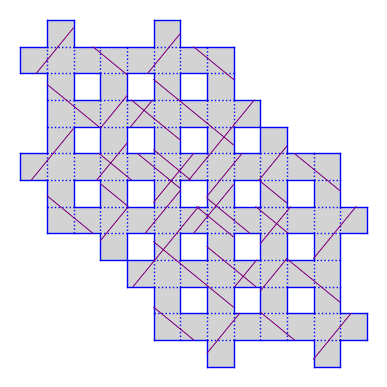

In [16]:
# add the trajectory:
plt + traj.plot(gs, color="purple", thickness=0.5)

### 3D graphics:
Here we can play around with 3-D Models of the surface. Note these are not visible in the pdf version. To actually see these, you must run it yourself.

In [17]:
# Here we plot the chunk of surface in the labels set constructed above
plt = m3d.plot(labels,label_to_color=label_to_color)
plt

Graphics3d Object

In [18]:
# The line m3d(traj) converts the trajectory to a list of vertices in R^3,
# which we can then plot with line3d.
plt + line3d(m3d(traj),radius=0.04,label_to_color=label_to_color)

Graphics3d Object

### New 2D projection.
It is a bit intensive to render a 3-dimensional image, so let's project the surface and the trajectory onto the rhombile tiling.

In [26]:
# Here is how you can extract the labels from the cylinder:
labels = {seg.polygon_label() for seg in traj.segments()}
for label in labels:
    gs.make_visible(label)

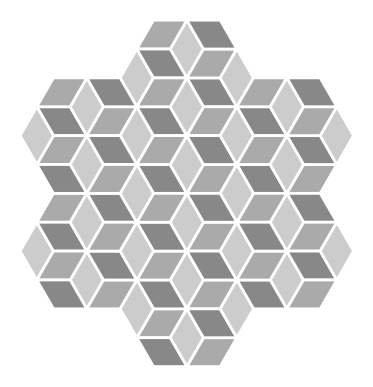

In [25]:
# Plot the polygons with those labels:
plt = m2d.plot(labels)
show(plt, axes=False)

In [27]:
# Build a tangent vector on the surface:
tangent_vector = s.tangent_vector(s.base_label(),(1/2,0),(9,11))
# arguments are (base_label, initial point (on square), initial direction as vector pair)
# Convert it to a straight-line trajectory:
traj = tangent_vector.straight_line_trajectory()
# Flow it:
traj.flow(1000)
# Check if it closed:
if traj.is_closed():
    print("Trajectory is closed.")
else:
    print("Trajectory is not closed.")


Trajectory is closed.


Since the trajectory only stores the faces that it crosses over, we can get "gaps" in our picture. For that reason, we have to enlarge the label set to fill in the gaps:

In [28]:
def enlarge_label_set(labels):
    while True:
        test_labels = set()
        for l in labels:
            for e in range(4):
                ll = s.opposite_edge(l,e)[0]
                if ll not in labels:
                    test_labels.add(ll)
        total_added = 0
        for ll in test_labels:
            count = 0
            for ee in range(4):
                lll = s.opposite_edge(ll,ee)[0]
                if lll in labels:
                    count += 1
            if count >= 2:
                total_added += 1
                labels.add(ll)
        if total_added == 0:
            break

Finally, we have the following:

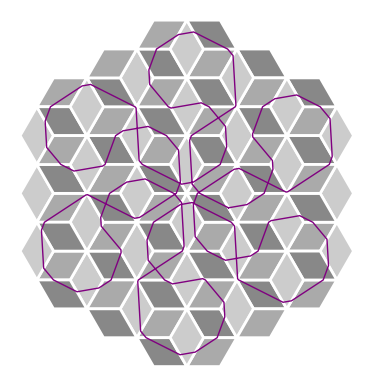

In [29]:
labels = {seg.polygon_label() for seg in traj.segments()}
for label in labels:
    gs.make_visible(label)
enlarge_label_set(labels)
plt = m2d.plot(labels)+ line2d(m2d(traj), color="purple", thickness=1.00)
show(plt,axes=false)

Now play around with it yourself!
Change the initial direction, and see what you can come up with! Note that if a trajectory hits a corner, the program just quits drawing it. That is because these are cone singularities, where geodesics are undefined. If your favorite direction hits one, try changing the starting point (argument 2 in s.tangent_vector)

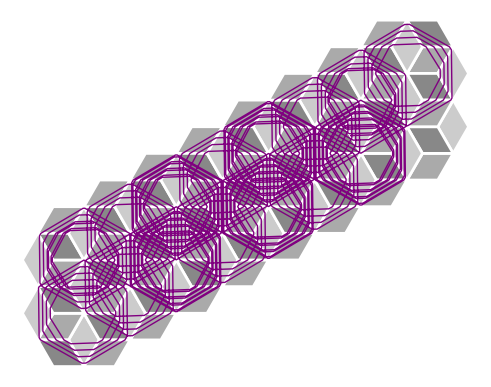

In [33]:
tv=s.tangent_vector(s.base_label(),(1/3,0), (71,74))
traj = tv.straight_line_trajectory()
traj.flow(1000)
labels = {seg.polygon_label() for seg in traj.segments()}
for label in labels:
    gs.make_visible(label)
enlarge_label_set(labels)
plt = m2d.plot(labels)+ line2d(m2d(traj), color="purple", thickness=1.00)
show(plt,axes=false)

If you want to save your plot as an image (or svg, pdf file), do the following and it will store it in your directory:

In [29]:
plt.save('image.svg',axes=false)

Have fun! :)